In [1]:
import pandas as pd
from pathlib import Path

# paths
PROJECT_ROOT = Path().resolve().parents[0]
train_path = PROJECT_ROOT / "data" / "processed" / "train.csv"
test_path  = PROJECT_ROOT / "data" / "processed" / "test.csv"


# load data
train = pd.read_csv(train_path)
test  = pd.read_csv(test_path)

print("Train shape:", train.shape, "| Test shape:", test.shape)
print("Columns:", train.columns.tolist())


Train shape: (40000, 32) | Test shape: (10000, 32)
Columns: ['Brand', 'Model', 'Year', 'Condition', 'Mileage(km)', 'EngineSize(L)', 'FuelType', 'Horsepower', 'Torque', 'Transmission', 'DriveType', 'BodyType', 'Doors', 'Seats', 'Color', 'Interior', 'City', 'AccidentHistory', 'Insurance', 'RegistrationStatus', 'FuelEfficiency(L/100km)', 'PricePerKm', 'Price($)', 'OptionsCount', 'opt_cruise_control', 'opt_navigation', 'opt_heated_seats', 'opt_parking_sensors', 'opt_touchscreen', 'opt_bluetooth', 'opt_sunroof', 'opt_rear_camera']


In [2]:
import sys
from pathlib import Path

# Add project root to sys.path so "src" is importable
PROJECT_ROOT = Path().resolve().parents[0]
sys.path.append(str(PROJECT_ROOT))

In [3]:
# Target column
target_col = 'Price($)'

# Feature columns (exclude target and PricePerKm to avoid leakage)
feature_cols = [col for col in train.columns if col not in [target_col, 'PricePerKm']]

# Create X and y
X_train = train[feature_cols]
y_train = train[target_col]

X_test = test[feature_cols]
y_test = test[target_col]

# Quick check
print("Feature columns used for modeling:", X_train.columns.tolist())
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

Feature columns used for modeling: ['Brand', 'Model', 'Year', 'Condition', 'Mileage(km)', 'EngineSize(L)', 'FuelType', 'Horsepower', 'Torque', 'Transmission', 'DriveType', 'BodyType', 'Doors', 'Seats', 'Color', 'Interior', 'City', 'AccidentHistory', 'Insurance', 'RegistrationStatus', 'FuelEfficiency(L/100km)', 'OptionsCount', 'opt_cruise_control', 'opt_navigation', 'opt_heated_seats', 'opt_parking_sensors', 'opt_touchscreen', 'opt_bluetooth', 'opt_sunroof', 'opt_rear_camera']
X_train shape: (40000, 30)
y_train shape: (40000,)


In [4]:
import pandas as pd

# --- Step 2a: Option flags ---
option_cols = [col for col in X_train.columns if col.startswith('opt_')]
X_train.loc[:, option_cols] = X_train[option_cols].astype(int)
X_test.loc[:, option_cols]  = X_test[option_cols].astype(int)

# --- Step 2b: Identify categorical columns (excluding option flags) ---
cat_cols = X_train.select_dtypes(include='object').columns.tolist()
print("Categorical columns:", cat_cols)

# --- Step 2c: Handle high-cardinality column 'Model' if it exists ---
if 'Model' in X_train.columns:
    freq = X_train['Model'].value_counts(normalize=True)
    X_train.loc[:, 'Model_freq'] = X_train['Model'].map(freq)
    X_test.loc[:, 'Model_freq'] = X_test['Model'].map(freq).fillna(0)
    X_train = X_train.drop(columns=['Model'])
    X_test  = X_test.drop(columns=['Model'])
else:
    print("Column 'Model' not found, skipping frequency encoding.")

# --- Step 2d: One-Hot encode remaining categorical columns ---
one_hot_cols = [c for c in cat_cols if c != 'Model']
X_train = pd.get_dummies(X_train, columns=one_hot_cols, drop_first=True)
X_test  = pd.get_dummies(X_test,  columns=one_hot_cols, drop_first=True)

# --- Step 2e: Align train and test columns ---
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

print("X_train shape after encoding:", X_train.shape)
print("X_test shape after encoding:", X_test.shape)


Categorical columns: ['Brand', 'Model', 'Condition', 'FuelType', 'Transmission', 'DriveType', 'BodyType', 'Color', 'Interior', 'City', 'AccidentHistory', 'Insurance', 'RegistrationStatus']
X_train shape after encoding: (40000, 65)
X_test shape after encoding: (10000, 65)


C:\Users\User\AppData\Local\Temp\ipykernel_20596\4212232903.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.loc[:, 'Model_freq'] = X_train['Model'].map(freq)
C:\Users\User\AppData\Local\Temp\ipykernel_20596\4212232903.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.loc[:, 'Model_freq'] = X_test['Model'].map(freq).fillna(0)


In [5]:
import json
from pathlib import Path

# --- Save the Model frequency map ---
if 'Model_freq' in X_train.columns:
    model_freq_map = freq.to_dict()   # freq created earlier
    save_path = Path().resolve().parents[0] / "models" / "model_freq_map.json"
    
    with open(save_path, "w") as f:
        json.dump(model_freq_map, f, indent=2)
    
    print(f"Model frequency map saved at: {save_path}")
else:
    print("No Model frequency encoding found to save.")


Model frequency map saved at: C:\Users\User\Desktop\Projects\Car_Price\models\model_freq_map.json


In [6]:
# --- Cross-validation on training set only (no leakage) ---
from sklearn.model_selection import KFold, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import numpy as np
import pandas as pd

cv = KFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    "MAE": "neg_mean_absolute_error",
    "RMSE": "neg_root_mean_squared_error",  # if older sklearn, compute RMSE later
    "R2": "r2",
}

cv_results = []

# Linear Regression
lr_cv = cross_validate(LinearRegression(), X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)
cv_results.append(["LinearRegression",
                   -np.mean(lr_cv["test_MAE"]),
                   -np.mean(lr_cv["test_RMSE"]),
                   np.mean(lr_cv["test_R2"])])

# Random Forest
rf_cv = cross_validate(
    RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1),
    X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1
)
cv_results.append(["RandomForest",
                   -np.mean(rf_cv["test_MAE"]),
                   -np.mean(rf_cv["test_RMSE"]),
                   np.mean(rf_cv["test_R2"])])

# LightGBM
lgb_cv = cross_validate(
    lgb.LGBMRegressor(n_estimators=400, learning_rate=0.05, random_state=42, n_jobs=-1),
    X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1
)
cv_results.append(["LightGBM",
                   -np.mean(lgb_cv["test_MAE"]),
                   -np.mean(lgb_cv["test_RMSE"]),
                   np.mean(lgb_cv["test_R2"])])

cv_table = pd.DataFrame(cv_results, columns=["Model", "CV_MAE", "CV_RMSE", "CV_R2"]).sort_values("CV_RMSE")
print("5-Fold CV summary (lower is better for MAE/RMSE):")
display(cv_table)

5-Fold CV summary (lower is better for MAE/RMSE):


,Model,CV_MAE,CV_RMSE,CV_R2
2,LightGBM,906.478222,1587.968017,0.990461
1,RandomForest,979.562472,1867.469897,0.986786
0,LinearRegression,5590.098603,7907.039012,0.763839


In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Initialize Linear Regression
lr_model = LinearRegression()

# Train model
lr_model.fit(X_train, y_train)

# Predict on test set
y_pred = lr_model.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # fixed for older scikit-learn
r2 = r2_score(y_test, y_pred)

print(f"Linear Regression Results:\nMAE: {mae:.2f}\nRMSE: {rmse:.2f}\nR2: {r2:.4f}")


Linear Regression Results:
MAE: 5597.51
RMSE: 7882.59
R2: 0.7619


In [8]:
from sklearn.ensemble import RandomForestRegressor

# Initialize Random Forest
rf_model = RandomForestRegressor(
    n_estimators=100,       # number of trees
    max_depth=None,         # grow until all leaves are pure
    random_state=42,
    n_jobs=-1
)

# Train model
rf_model.fit(X_train, y_train)

# Predict on test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest Results:\nMAE: {mae_rf:.2f}\nRMSE: {rmse_rf:.2f}\nR2: {r2_rf:.4f}")


Random Forest Results:
MAE: 952.08
RMSE: 1800.90
R2: 0.9876


In [9]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint, uniform
import numpy as np

rf = RandomForestRegressor(random_state=42, n_jobs=-1)

rf_dist = {
    "n_estimators": randint(200, 800),
    "max_depth": randint(6, 30),      # None is powerful; keep moderate depths for speed
    "min_samples_split": randint(2, 10),
    "min_samples_leaf": randint(1, 5),
    "max_features": ["sqrt", "log2", None],
}

rf_search = RandomizedSearchCV(
    rf,
    rf_dist,
    n_iter=25,
    scoring="neg_mean_absolute_error",
    cv=3,
    verbose=0,
    random_state=42,
    n_jobs=-1,
)

rf_search.fit(X_train, y_train)
rf_best = rf_search.best_estimator_
print("Best RF params:", rf_search.best_params_)

# Evaluate tuned RF on test set
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
y_pred_rf_tuned = rf_best.predict(X_test)
mae_rf_tuned = mean_absolute_error(y_test, y_pred_rf_tuned)
rmse_rf_tuned = np.sqrt(mean_squared_error(y_test, y_pred_rf_tuned))
r2_rf_tuned = r2_score(y_test, y_pred_rf_tuned)
print(f"Tuned RF  | MAE: {mae_rf_tuned:.2f}  RMSE: {rmse_rf_tuned:.2f}  R2: {r2_rf_tuned:.4f}")

Best RF params: {'max_depth': 26, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 414}
Tuned RF  | MAE: 958.37  RMSE: 1824.04  R2: 0.9873


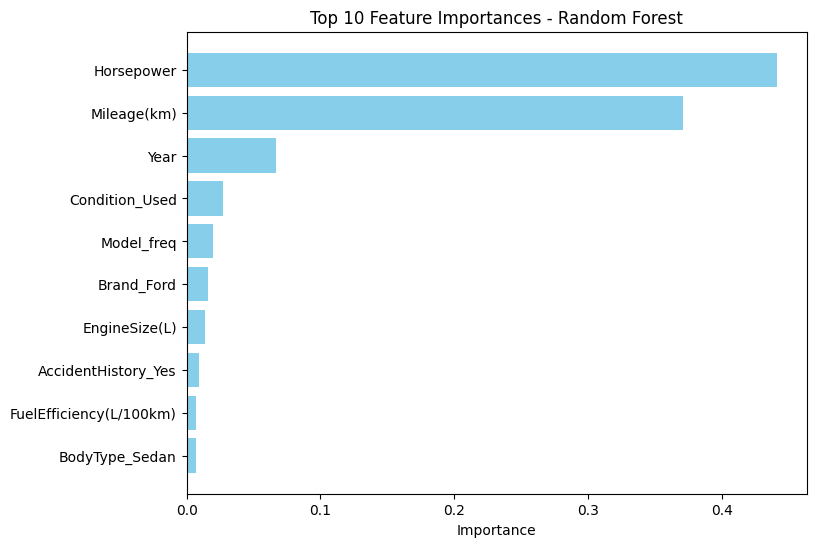

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Get top 10 important features
importances = rf_model.feature_importances_
indices = np.argsort(importances)[-10:][::-1]
feature_names = X_train.columns[indices]

plt.figure(figsize=(8,6))
plt.barh(feature_names, importances[indices], color='skyblue')
plt.title("Top 10 Feature Importances - Random Forest")
plt.xlabel("Importance")
plt.gca().invert_yaxis()
plt.show()


In [11]:
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Initialize LGBM Regressor
lgb_model = lgb.LGBMRegressor(
    n_estimators=500,      # number of boosting rounds
    learning_rate=0.05,
    max_depth=-1,
    random_state=42,
    n_jobs=-1
)

# Train model
lgb_model.fit(X_train, y_train)  # no early stopping

# Predict on test set
y_pred_lgb = lgb_model.predict(X_test)

# Evaluate
mae_lgb = mean_absolute_error(y_test, y_pred_lgb)
rmse_lgb = np.sqrt(mean_squared_error(y_test, y_pred_lgb))
r2_lgb = r2_score(y_test, y_pred_lgb)

print(f"LightGBM Results:\nMAE: {mae_lgb:.2f}\nRMSE: {rmse_lgb:.2f}\nR2: {r2_lgb:.4f}")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003760 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1250
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 65
[LightGBM] [Info] Start training from score 15697.329717
LightGBM Results:
MAE: 900.71
RMSE: 1584.93
R2: 0.9904


In [12]:
import lightgbm as lgb
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

lgb_base = lgb.LGBMRegressor(random_state=42, n_jobs=-1)

lgb_dist = {
    "n_estimators": randint(300, 900),
    "learning_rate": uniform(0.01, 0.09),  # 0.01–0.10
    "num_leaves": randint(20, 80),
    "max_depth": randint(-1, 18),          # -1 lets tree grow unconstrained
    "subsample": uniform(0.6, 0.4),        # 0.6–1.0
    "colsample_bytree": uniform(0.6, 0.4),
    "reg_alpha": uniform(0.0, 0.4),
    "reg_lambda": uniform(0.0, 0.4),
}

lgb_search = RandomizedSearchCV(
    lgb_base,
    lgb_dist,
    n_iter=30,
    scoring="neg_mean_absolute_error",
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=0,
)

lgb_search.fit(X_train, y_train)
lgb_best = lgb_search.best_estimator_
print("Best LGBM params:", lgb_search.best_params_)

# Evaluate tuned LGBM on test set
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
y_pred_lgb_tuned = lgb_best.predict(X_test)
mae_lgb_tuned = mean_absolute_error(y_test, y_pred_lgb_tuned)
rmse_lgb_tuned = np.sqrt(mean_squared_error(y_test, y_pred_lgb_tuned))
r2_lgb_tuned = r2_score(y_test, y_pred_lgb_tuned)
print(f"Tuned LGBM| MAE: {mae_lgb_tuned:.2f}  RMSE: {rmse_lgb_tuned:.2f}  R2: {r2_lgb_tuned:.4f}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002099 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1250
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 65
[LightGBM] [Info] Start training from score 15697.329717
Best LGBM params: {'colsample_bytree': np.float64(0.6307919639315172), 'learning_rate': np.float64(0.03607763076223912), 'max_depth': 0, 'n_estimators': 856, 'num_leaves': 76, 'reg_alpha': np.float64(0.04219770393210825), 'reg_lambda': np.float64(0.1826138281931641), 'subsample': np.float64(0.6873761748867334)}
Tuned LGBM| MAE: 865.30  RMSE: 1545.62  R2: 0.9908


In [13]:
import pandas as pd

results = []

# Baselines (rename variables if yours differ)
results.append(["LinearRegression", mae, rmse, r2])
results.append(["RandomForest", mae_rf, rmse_rf, r2_rf])
results.append(["LightGBM", mae_lgb, rmse_lgb, r2_lgb])

# Tuned models (only if you ran the searches)
results.append(["RandomForest (tuned)", mae_rf_tuned, rmse_rf_tuned, r2_rf_tuned])
results.append(["LightGBM (tuned)", mae_lgb_tuned, rmse_lgb_tuned, r2_lgb_tuned])

results_df = pd.DataFrame(results, columns=["Model", "MAE", "RMSE", "R2"]).sort_values("RMSE")
print("Model comparison on TEST set:")
display(results_df)

Model comparison on TEST set:


,Model,MAE,RMSE,R2
4,LightGBM (tuned),865.301750,1545.622428,0.990847
2,LightGBM,900.714500,1584.925448,0.990376
1,RandomForest,952.080002,1800.898594,0.987574
3,RandomForest (tuned),958.368564,1824.043104,0.987253
0,LinearRegression,5597.508920,7882.585873,0.761939


In [14]:
import json
from pathlib import Path

PROJECT_ROOT = Path().resolve().parents[0]
with open(PROJECT_ROOT / "models" / "feature_columns.json", "w") as f:
    json.dump({"columns": X_train.columns.tolist()}, f, indent=2)


In [15]:
# FI-0: pick the model to explain + ensure figure dir
from pathlib import Path
import os

# Choose the best available model (prefer tuned LightGBM)
model_for_explain = None
for name in ["lgb_best", "lgb_model", "rf_model", "lr_model"]:
    if name in globals():
        model_for_explain = globals()[name]
        print(f"Explaining model: {name}")
        break

assert model_for_explain is not None, "No trained model found to explain."

# Figure output dir (for your report/screenshots)
PROJECT_ROOT = Path().resolve().parents[0]
FIG_DIR = PROJECT_ROOT / "reports" / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)


Explaining model: lgb_best


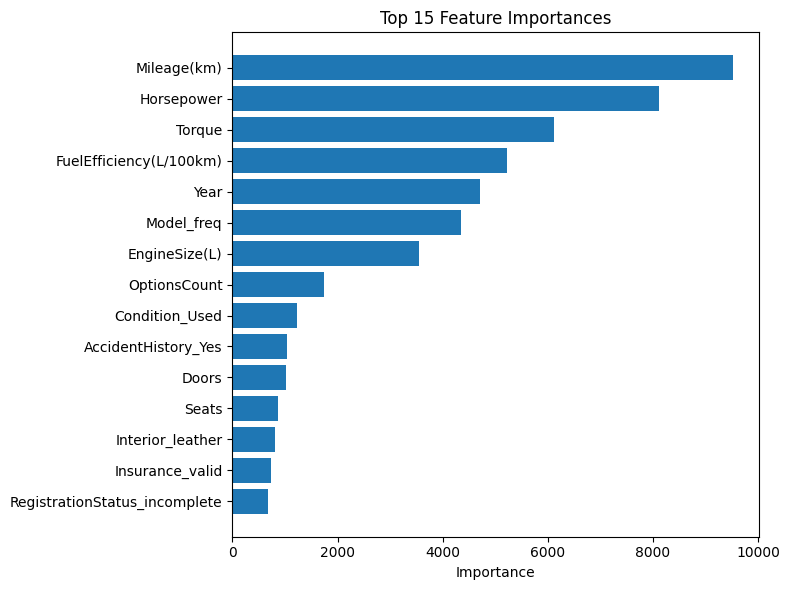

Saved: C:\Users\User\Desktop\Projects\Car_Price\reports\figures\feature_importance_tree_top15.png


In [16]:
# FI-1: built-in feature importances (tree models)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

if hasattr(model_for_explain, "feature_importances_"):
    importances = pd.Series(model_for_explain.feature_importances_, index=X_train.columns)
    topN = 15
    top_imp = importances.sort_values(ascending=False).head(topN)[::-1]  # reverse for barh

    plt.figure(figsize=(8, 6))
    plt.barh(top_imp.index, top_imp.values)
    plt.title(f"Top {topN} Feature Importances")
    plt.xlabel("Importance")
    plt.tight_layout()
    out_path = FIG_DIR / "feature_importance_tree_top15.png"
    plt.savefig(out_path, dpi=150)
    plt.show()
    print("Saved:", out_path)
else:
    print("This model does not expose 'feature_importances_' (e.g., LinearRegression).")


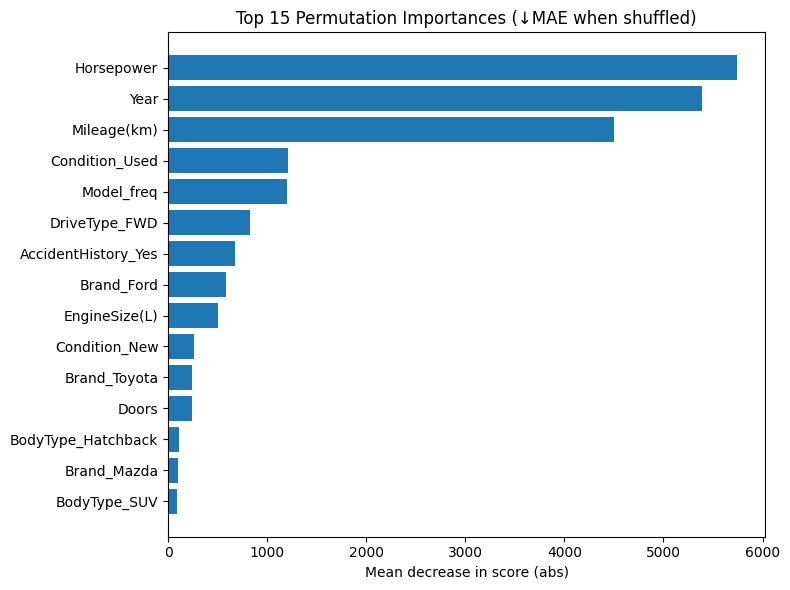

Saved: C:\Users\User\Desktop\Projects\Car_Price\reports\figures\feature_importance_permutation_top15.png


In [17]:
# FI-2: permutation importance on TEST (model-agnostic)
from sklearn.inspection import permutation_importance

# smaller repeats for speed; increase to 10 for thorough analysis
perm = permutation_importance(
    model_for_explain, X_test, y_test,
    n_repeats=5, random_state=42, scoring="neg_mean_absolute_error"
)

perm_imp = pd.Series(perm.importances_mean, index=X_test.columns).sort_values(ascending=False)
topN = 15
top_perm = perm_imp.head(topN)[::-1]  # for barh

plt.figure(figsize=(8, 6))
plt.barh(top_perm.index, top_perm.values)
plt.title(f"Top {topN} Permutation Importances (↓MAE when shuffled)")
plt.xlabel("Mean decrease in score (abs)")
plt.tight_layout()
out_path = FIG_DIR / "feature_importance_permutation_top15.png"
plt.savefig(out_path, dpi=150)
plt.show()
print("Saved:", out_path)


c:\Users\User\anaconda3\envs\usedcar\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


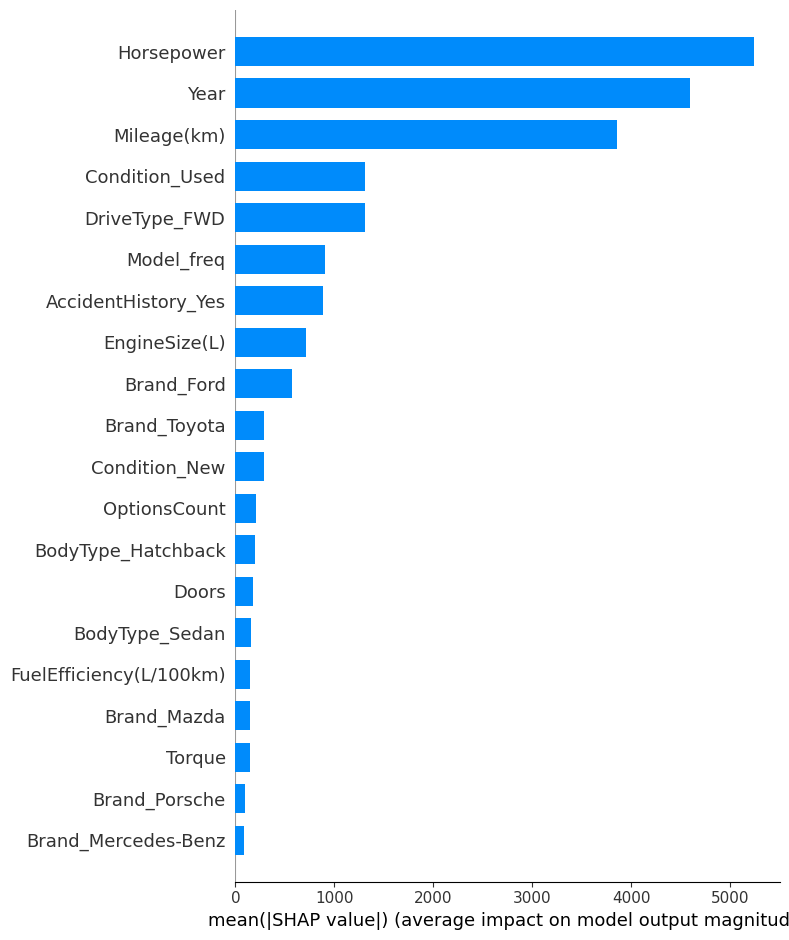

Saved: C:\Users\User\Desktop\Projects\Car_Price\reports\figures\shap_summary_bar.png


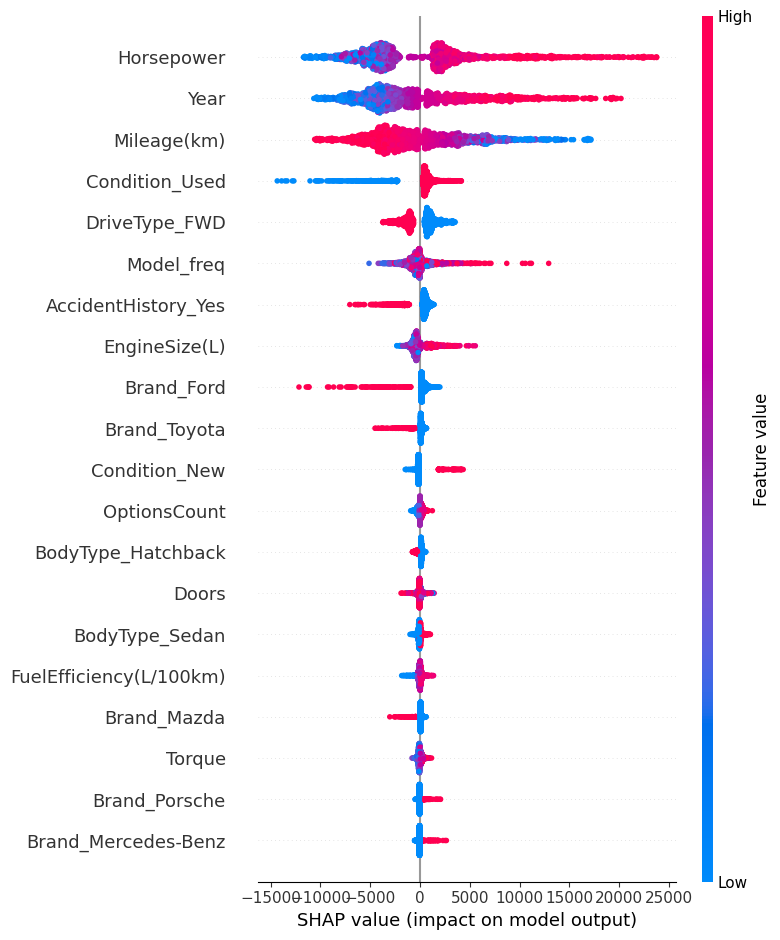

Saved: C:\Users\User\Desktop\Projects\Car_Price\reports\figures\shap_summary_beeswarm.png


In [18]:
# FI-3 (optional): SHAP summary for LightGBM (tree explainer)
try:
    import shap

    # Use TreeExplainer for tree models
    explainer = shap.TreeExplainer(model_for_explain)
    # Use a manageable slice of X_test for speed
    X_sample = X_test.sample(n=min(2000, len(X_test)), random_state=42)
    shap_values = explainer.shap_values(X_sample)

    # Global summary plot (bar)
    shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False)
    out_path = FIG_DIR / "shap_summary_bar.png"
    plt.tight_layout()
    plt.savefig(out_path, dpi=150, bbox_inches="tight")
    plt.show()
    print("Saved:", out_path)

    # Global summary plot (beeswarm)
    shap.summary_plot(shap_values, X_sample, show=False)
    out_path = FIG_DIR / "shap_summary_beeswarm.png"
    plt.tight_layout()
    plt.savefig(out_path, dpi=150, bbox_inches="tight")
    plt.show()
    print("Saved:", out_path)

except Exception as e:
    print("SHAP not run. Reason:", e)
    print("Tip: install SHAP ('pip install shap') and ensure you have a tree model (LightGBM/RandomForest).")


In [19]:
import joblib, os
from pathlib import Path

PROJECT_ROOT = Path().resolve().parents[0]
model_dir = PROJECT_ROOT / "models"
os.makedirs(model_dir, exist_ok=True)

# Use tuned model if available, else fall back to baseline
final_model = "lgb_best" in globals() and lgb_best or lgb_model

model_path = model_dir / "lightgbm_model.pkl"
joblib.dump(final_model, model_path)
print(f"Saved LightGBM model to: {model_path}")

Saved LightGBM model to: C:\Users\User\Desktop\Projects\Car_Price\models\lightgbm_model.pkl


In [20]:
import joblib
from pathlib import Path

# Project root = one level up from notebooks/
PROJECT_ROOT = Path().resolve().parents[0]
model_path = PROJECT_ROOT / "models" / "lightgbm_model.pkl"

# Load the model
loaded_model = joblib.load(model_path)

# Predict on test data
y_pred_loaded = loaded_model.predict(X_test)

print("Predictions:", y_pred_loaded[:5])

Predictions: [ 3529.71576773  9265.12511546 19838.03399301  3914.78023727
 17362.69320239]


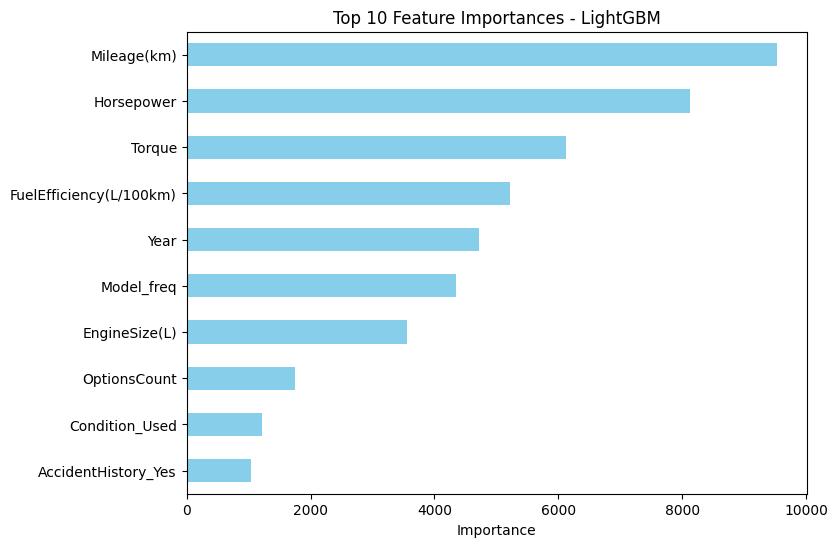

In [21]:
import matplotlib.pyplot as plt
import pandas as pd

# Get feature importances from the loaded LightGBM model
feat_imp = pd.Series(loaded_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot top 10 features
plt.figure(figsize=(8,6))
feat_imp.head(10).plot(kind='barh', color='skyblue')
plt.title("Top 10 Feature Importances - LightGBM")
plt.xlabel("Importance")
plt.gca().invert_yaxis()  # largest at top
plt.show()

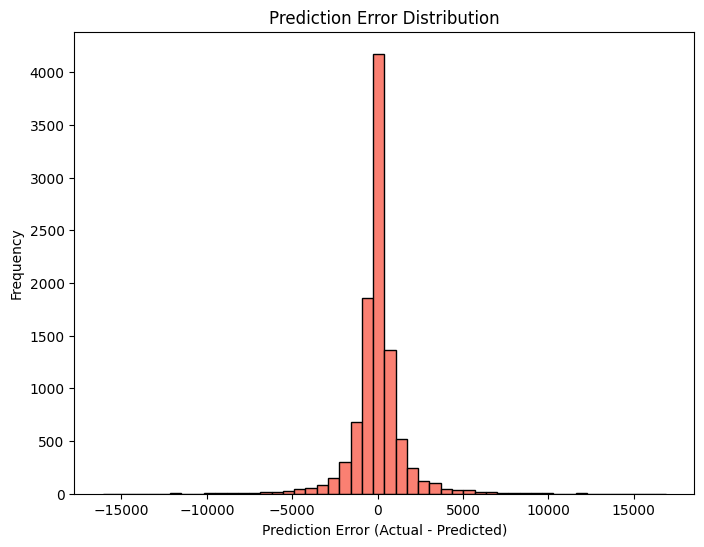

In [22]:
import numpy as np

# Calculate prediction errors
errors = y_test - y_pred_loaded

# Plot histogram of errors
plt.figure(figsize=(8,6))
plt.hist(errors, bins=50, color='salmon', edgecolor='black')
plt.title("Prediction Error Distribution")
plt.xlabel("Prediction Error (Actual - Predicted)")
plt.ylabel("Frequency")
plt.show()


In [23]:
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

cluster_features = [c for c in ["Mileage(km)", "Year", "Horsepower", "EngineSize(L)"] if c in train.columns]
print("Clustering features:", cluster_features)


Clustering features: ['Mileage(km)', 'Year', 'Horsepower', 'EngineSize(L)']


In [24]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
Xc_train = scaler.fit_transform(train[cluster_features])
Xc_test  = scaler.transform(test[cluster_features])


In [25]:
# CELL C — (optional) k sweep
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

ks = range(2, 7)
inertias, sils = [], []
for k in ks:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    lbl = km.fit_predict(Xc_train)
    inertias.append(km.inertia_)
    sils.append(silhouette_score(Xc_train, lbl))

print("k  | inertia    | silhouette")
for k, i, s in zip(ks, inertias, sils):
    print(f"{k:<2} | {i:>10.0f} | {s:.3f}")


c:\Users\User\anaconda3\envs\usedcar\lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


k  | inertia    | silhouette
2  |     113558 | 0.296
3  |      84751 | 0.289
4  |      67744 | 0.309
5  |      53089 | 0.353
6  |      42473 | 0.342


In [26]:
# CELL E — final KMeans fit (Xc_train is already scaled) + label mapping by median price
from sklearn.cluster import KMeans

k = 3
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
train_clusters = kmeans.fit_predict(Xc_train)

# Attach clusters to TRAIN
train_seg = train.copy()
train_seg["Cluster"] = train_clusters

# Name clusters by median Price($) on TRAIN (ascending)
med_by_cluster = train_seg.groupby("Cluster")["Price($)"].median().sort_values()
ranked = med_by_cluster.index.tolist()
label_map = (
    {ranked[0]: "Budget", ranked[1]: "Mid-range", ranked[2]: "Luxury"}
    if len(ranked) == 3 else {i: f"Cluster {i}" for i in ranked}
)

# Map Segment on TRAIN (this line was missing)
train_seg["Segment"] = train_seg["Cluster"].map(label_map)

# Predict clusters for TEST and map Segment
test_clusters = kmeans.predict(Xc_test)
test_seg = test.copy()
test_seg["Cluster"] = test_clusters
test_seg["Segment"] = test_seg["Cluster"].map(label_map)

print("Cluster → Segment mapping:", label_map)


Cluster → Segment mapping: {0: 'Budget', 1: 'Mid-range', 2: 'Luxury'}


In [27]:
print("Cols:", list(train_seg.columns)[:20])
print(train_seg[["Cluster"]].head())
print("'Segment' present?", "Segment" in train_seg.columns)
print("label_map:", label_map)


Cols: ['Brand', 'Model', 'Year', 'Condition', 'Mileage(km)', 'EngineSize(L)', 'FuelType', 'Horsepower', 'Torque', 'Transmission', 'DriveType', 'BodyType', 'Doors', 'Seats', 'Color', 'Interior', 'City', 'AccidentHistory', 'Insurance', 'RegistrationStatus']
   Cluster
0        1
1        1
2        0
3        1
4        0
'Segment' present? True
label_map: {0: 'Budget', 1: 'Mid-range', 2: 'Luxury'}


In [28]:
profile_cols = [c for c in ["Mileage(km)", "Year", "Horsepower", "EngineSize(L)"] if c in train_seg.columns]

# If Segment isn't present, create it from Cluster with a fallback label_map
if "Segment" not in train_seg.columns:
    if "label_map" in globals() and isinstance(label_map, dict) and len(label_map):
        train_seg["Segment"] = train_seg["Cluster"].map(label_map)
    else:
        # fallback: generic names
        unique_clusters = sorted(train_seg["Cluster"].unique())
        fallback_map = {i: f"Cluster {i}" for i in unique_clusters}
        train_seg["Segment"] = train_seg["Cluster"].map(fallback_map)

cluster_profile = (
    train_seg
    .groupby("Segment")[profile_cols]
    .mean(numeric_only=True)
    .round(2)
    .sort_values(by="Mileage(km)", ascending=True)
)
cluster_profile


,Mileage(km),Year,Horsepower,EngineSize(L)
Segment,,,,
Luxury,9.54,2022.84,5.45,1.95
Mid-range,11.98,2013.16,5.92,3.20
Budget,12.10,2012.07,5.16,1.39


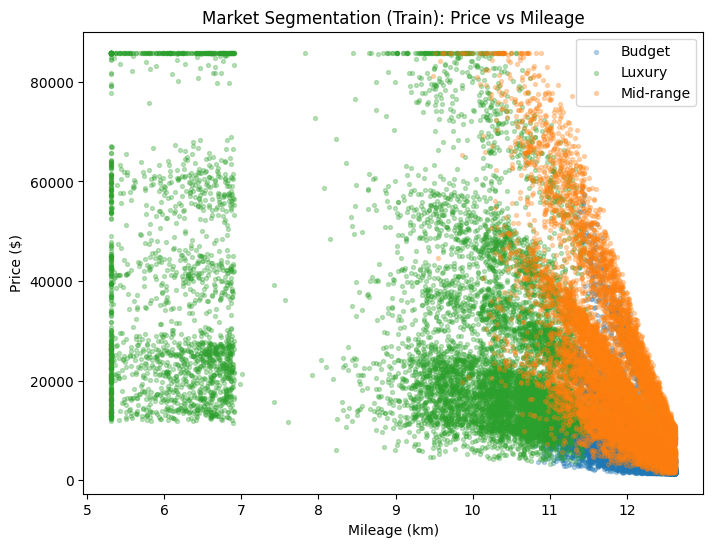

In [29]:
# Scatter: Price vs Mileage colored by segment (train only)
import matplotlib.pyplot as plt

if "Price($)" in train_seg.columns and "Mileage(km)" in train_seg.columns:
    colors = {"Budget":"tab:blue","Mid-range":"tab:orange","Luxury":"tab:green"}
    plt.figure(figsize=(8,6))
    for seg, df_seg in train_seg.groupby("Segment"):
        plt.scatter(df_seg["Mileage(km)"], df_seg["Price($)"], s=8, alpha=0.3, label=seg, c=colors.get(seg, None))
    plt.xlabel("Mileage (km)")
    plt.ylabel("Price ($)")
    plt.title("Market Segmentation (Train): Price vs Mileage")
    plt.legend()
    plt.show()


In [30]:
# CELL F — persist artifacts with the new feature list
import json, joblib
from pathlib import Path

PROJECT_ROOT = Path().resolve().parents[0]
MODELS_DIR   = PROJECT_ROOT / "models"
REPORTS_DIR  = PROJECT_ROOT / "reports" / "results"
MODELS_DIR.mkdir(parents=True, exist_ok=True)
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

joblib.dump(kmeans, MODELS_DIR / "kmeans.pkl")
joblib.dump(scaler, MODELS_DIR / "kmeans_scaler.pkl")
with open(MODELS_DIR / "kmeans_features.json", "w") as f:
    json.dump({"features": cluster_features, "label_map": label_map}, f, indent=2)

cluster_profile.to_csv(REPORTS_DIR / "cluster_profile.csv", index=True)

print("Saved kmeans.pkl, kmeans_scaler.pkl, kmeans_features.json, cluster_profile.csv")

Saved kmeans.pkl, kmeans_scaler.pkl, kmeans_features.json, cluster_profile.csv


In [31]:
import json, pathlib
p = pathlib.Path().resolve().parents[0] / "models" / "kmeans_features.json"
print(json.load(open(p))["features"])


['Mileage(km)', 'Year', 'Horsepower', 'EngineSize(L)']


In [32]:
# from pathlib import Path
# from src.inference import load_artifacts, predict_and_cluster
# art = load_artifacts(Path().resolve().parents[0])
# predict_and_cluster(sample, art)


In [33]:
from pathlib import Path
from src.inference import load_artifacts, predict_and_cluster

art = load_artifacts(Path().resolve().parents[0])

sample = {
    "Brand":"Toyota","Model":"Corolla","Year":2018,"Condition":"Used",
    "Mileage(km)":84000,"EngineSize(L)":1.6,"FuelType":"Gasoline",
    "Horsepower":132,"Torque":128,"Transmission":"Automatic","DriveType":"FWD",
    "BodyType":"Sedan","Doors":4,"Seats":5,"Color":"White","Interior":"Cloth",
    "City":"Berlin","AccidentHistory":"No","Insurance":"Valid","RegistrationStatus":"Complete",
    "FuelEfficiency(L/100km)":6.8,"Options":"bluetooth, rear camera, navigation"
}

predict_and_cluster(sample, art)


{'predicted_price': 12540.410306948284,
 'cluster_label': 0,
 'cluster_name': 'Budget'}

In [34]:
from pathlib import Path
from src.inference import load_artifacts
from src.recommend import load_catalog, budget_recommendations, similar_items

root = Path().resolve().parents[0]
art  = load_artifacts(root)
cat  = load_catalog(root)

sample = {
    "Brand": "Toyota", "Model": "Corolla", "Year": 2018, "Condition": "Used",
    "Mileage(km)": 85000, "EngineSize(L)": 1.6, "FuelType": "Gasoline",
    "Horsepower": 132, "Torque": 128, "Transmission": "Automatic", "DriveType": "FWD",
    "BodyType": "Sedan", "Doors": 4, "Seats": 5, "Color": "White", "Interior": "Cloth",
    "City": "Berlin", "AccidentHistory": "No", "Insurance": "Valid",
    "RegistrationStatus": "Complete", "FuelEfficiency(L/100km)": 6.8,
    "Options": "bluetooth, rear camera, navigation"
}

print("Top by budget window (±15% around predicted price)")
budget_recommendations(sample, cat, art, pct=0.15, top_n=10).head(10)


Top by budget window (±15% around predicted price)


,rec_id,PredPriceUser,Brand,Model,Year,Condition,Price($),Mileage(km),EngineSize(L),Horsepower,Doors,Seats,FuelType,Transmission,DriveType,BodyType,Color,Interior,City,similarity
0,4016,12540.0,Porsche,718 Cayman,2009,Used,10992,12,2.0,401,2,2,gasoline,manual,RWD,Coupe,black,cloth,Cape Town,0.03
1,25618,12540.0,Audi,Q7,2009,Used,10660,12,2.1,301,5,7,gasoline,automatic,AWD,SUV,black,cloth,Berlin,0.03
2,36073,12540.0,Porsche,718 Cayman,2010,Used,10845,12,2.7,367,2,2,gasoline,manual,RWD,Coupe,black,cloth,Tehran,0.03
3,4880,12540.0,Audi,A6,2010,Used,10905,12,2.1,285,4,5,gasoline,automatic,FWD,Sedan,white,leather,Berlin,0.03
4,15695,12540.0,BMW,7 Series,2007,Used,12312,13,0.0,452,4,5,electric,automatic,RWD,Sedan,blue,leather,Tehran,0.03
5,19918,12540.0,Tesla,Model S,2007,Used,11682,13,0.0,848,5,5,electric,automatic,AWD,Sedan,white,leather,Paris,0.03
6,26492,12540.0,BMW,7 Series,2006,Used,11014,13,0.0,479,4,4,electric,automatic,RWD,Sedan,black,leather,Dubai,0.03
7,38150,12540.0,Mercedes-Benz,E-Class,2012,Used,11712,12,2.1,302,4,5,diesel,manual,RWD,Sedan,black,cloth,Delhi,0.03
8,15667,12540.0,Audi,Q7,2010,Used,10761,12,2.1,297,5,7,gasoline,manual,AWD,SUV,white,leather,Los Angeles,0.03
9,467,12540.0,Audi,Q7,2010,Used,11422,12,2.2,319,5,7,gasoline,manual,AWD,SUV,black,cloth,Sao Paulo,0.03


In [35]:
import importlib, src.recommend as recommend
importlib.reload(recommend)
from src.recommend import load_catalog, recommend_by_budget_only, recommend_minimal


In [36]:
from pathlib import Path
from src.inference import load_artifacts
from src.recommend import load_catalog, recommend_by_budget_only, recommend_minimal

root = Path().resolve().parents[0]
art  = load_artifacts(root)
cat  = load_catalog(root)

print("Budget-only (USD 18000)")
rec_budget = recommend_by_budget_only(18000, cat, pct=0.15, top_n=10, filters={"BodyType":"Sedan"})
rec_budget

print("\nMinimal-5 (4 core + optional filter BodyType=Sedan)")
minimal_input = {"Mileage(km)": 85000, "Year": 2018, "Horsepower": 130, "EngineSize(L)": 1.6}
rec_min = recommend_minimal(minimal_input, cat, art, top_n=10, filters={"BodyType":"Sedan"})
rec_min


Budget-only (USD 18000)

Minimal-5 (4 core + optional filter BodyType=Sedan)


,rec_id,Brand,Model,Year,Condition,Price($),Mileage(km),EngineSize(L),Horsepower,Doors,Seats,FuelType,Transmission,DriveType,BodyType,Color,Interior,City,similarity
0,39971,Tesla,Model S,2005,Used,8500,13,0.0,848,5,5,electric,automatic,AWD,Sedan,silver,cloth,Delhi,0.03
1,28718,Tesla,Model S,2005,Used,8172,13,0.0,848,5,5,electric,automatic,AWD,Sedan,gray,cloth,Berlin,0.03
2,33859,Tesla,Model S,2005,Used,8610,13,0.0,848,5,5,electric,automatic,AWD,Sedan,black,leather,Sao Paulo,0.03
3,13762,Tesla,Model S,2005,Used,8521,13,0.0,848,5,5,electric,automatic,AWD,Sedan,red,leather,Tokyo,0.03
4,36582,Tesla,Model S,2005,Used,7461,13,0.0,848,5,5,electric,automatic,AWD,Sedan,black,leather,Delhi,0.03
5,3826,Tesla,Model S,2005,Used,8453,13,0.0,842,5,5,electric,automatic,AWD,Sedan,silver,cloth,Toronto,0.03
6,3217,Tesla,Model S,2005,Used,8384,13,0.0,837,5,5,electric,automatic,AWD,Sedan,silver,leather,Berlin,0.03
7,34366,Tesla,Model S,2005,Used,8462,13,0.0,832,5,5,electric,automatic,AWD,Sedan,red,leather,Sao Paulo,0.03
8,6841,Tesla,Model S,2005,Used,8550,13,0.0,826,5,5,electric,automatic,AWD,Sedan,gray,cloth,Tehran,0.03
9,25615,Tesla,Model S,2005,Used,7800,13,0.0,820,5,5,electric,automatic,AWD,Sedan,blue,cloth,Tehran,0.03


In [37]:
# V1 — Build metadata for version.json
from pathlib import Path
import json, hashlib, joblib, datetime
import pandas as pd

PROJECT_ROOT = Path().resolve().parents[0]
models_dir   = PROJECT_ROOT / "models"

# Load what we need
feature_cols = json.load(open(models_dir / "feature_columns.json"))["columns"]
feature_count = len(feature_cols)

# Hash the exact feature list for reproducibility
feat_text = "\n".join(feature_cols).encode("utf-8")
feature_list_hash = hashlib.md5(feat_text).hexdigest()[:10]  # short 10-char hash

# Identify model & params
model = joblib.load(models_dir / "lightgbm_model.pkl")
model_type = type(model).__name__
# LightGBM models have .get_params(); others too
model_params = getattr(model, "get_params", lambda: {} )()

# Optionally get train/test sizes from your CSVs
train_path = PROJECT_ROOT / "data" / "processed" / "train.csv"
test_path  = PROJECT_ROOT / "data" / "processed" / "test.csv"
n_train = pd.read_csv(train_path).shape[0] if train_path.exists() else None
n_test  = pd.read_csv(test_path).shape[0] if test_path.exists() else None

# Create record (edit strings as you like)
version_info = {
    "preprocessing_version": "v1.0-preproc-2025-10-01",
    "feature_list_hash": feature_list_hash,
    "feature_count": feature_count,
    "model_type": model_type,
    "model_params": model_params,
    "train_date": datetime.date.today().isoformat(),
    "random_seed": 42,
    "training_rows": n_train,
    "test_rows": n_test,
}
version_info


{'preprocessing_version': 'v1.0-preproc-2025-10-01',
 'feature_list_hash': '6c89bc15c9',
 'feature_count': 65,
 'model_type': 'LGBMRegressor',
 'model_params': {'boosting_type': 'gbdt',
  'class_weight': None,
  'colsample_bytree': np.float64(0.6307919639315172),
  'importance_type': 'split',
  'learning_rate': np.float64(0.03607763076223912),
  'max_depth': 0,
  'min_child_samples': 20,
  'min_child_weight': 0.001,
  'min_split_gain': 0.0,
  'n_estimators': 856,
  'n_jobs': -1,
  'num_leaves': 76,
  'objective': None,
  'random_state': 42,
  'reg_alpha': np.float64(0.04219770393210825),
  'reg_lambda': np.float64(0.1826138281931641),
  'subsample': np.float64(0.6873761748867334),
  'subsample_for_bin': 200000,
  'subsample_freq': 0},
 'train_date': '2025-10-01',
 'random_seed': 42,
 'training_rows': 40000,
 'test_rows': 10000}

In [38]:
# V2 — Save version.json
out_path = models_dir / "version.json"
with open(out_path, "w") as f:
    json.dump(version_info, f, indent=2)
print("Saved:", out_path)


Saved: C:\Users\User\Desktop\Projects\Car_Price\models\version.json


In [40]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

y_true = y_test.values
y_pred = final_model.predict(X_test)

mae  = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))  # <- no 'squared' arg
r2   = r2_score(y_true, y_pred)

print(f"MAE: {mae:,.2f}")
print(f"RMSE: {rmse:,.2f}")
print(f"R²: {r2:.4f}")


MAE: 865.30
RMSE: 1,545.62
R²: 0.9908


In [41]:
from pathlib import Path
p = Path().resolve().parents[0] / "reports" / "results" / "cluster_profile.csv"
print(p, "| exists:", p.exists())

C:\Users\User\Desktop\Projects\Car_Price\reports\results\cluster_profile.csv | exists: True


In [42]:
from pathlib import Path
p1 = Path().resolve().parents[0] / "reports" / "figures" / "lgbm_feature_importance.png"
p2 = Path().resolve().parents[0] / "reports" / "figures" / "permutation_importance.png"
print("Feature importance exists:", p1.exists())
print("Permutation importance exists:", p2.exists())


Feature importance exists: False
Permutation importance exists: False
